In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('AReviews.csv')
df=df[:10000]
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Text Cleaning or Preprocessing

In [3]:
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 10000):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
corpus=pd.DataFrame(corpus, columns=['Text']) 
corpus.head()

,Text
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [5]:
result=corpus.join(df[['Score']])
result.head()

,Text,Score
0,bought sever vital can dog food product found ...,5
1,product arriv label jumbo salt peanut peanut a...,1
2,confect around centuri light pillowi citru gel...,4
3,look secret ingredi robitussin believ found go...,2
4,great taffi great price wide assort yummi taff...,5


# TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(result['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [7]:
X = tfidf.transform(result['Text'])
result['Text'][1]

'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo'

In [8]:
print([X[1, tfidf.vocabulary_['error']]])

[0.2706003734708304]


In [9]:
print([X[1, tfidf.vocabulary_['peanut']]])

[0.37509695630835344]


In [10]:
print([X[1, tfidf.vocabulary_['jumbo']]])

[0.5727828521365451]


# Sentiment Classification(DUYGU SINIFLANDIRMASI)

In [11]:
result.dropna(inplace=True)
result[result['Score'] != 3]
result['Positivity'] = np.where(result['Score'] > 3, 1, 0)
cols = [ 'Score']
result.drop(cols, axis=1, inplace=True)
result.head()

,Text,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [12]:
result.groupby('Positivity').size()

Positivity
0    2384
1    7616
dtype: int64

# Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
X = result.Text
y = result.Positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [14]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 7500 entries with 23.57% negative, 76.43% positive


In [15]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 2500 entries with 24.64% negative, 75.36% positive


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [17]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,25001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [19]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 10000 features


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 82.96%
Test result for 15000 features
accuracy score: 82.52%
Test result for 20000 features
accuracy score: 82.28%
Test result for 25000 features
accuracy score: 81.84%


In [20]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=10000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.71      0.52      0.60       616
    positive       0.86      0.93      0.89      1884

   micro avg       0.83      0.83      0.83      2500
   macro avg       0.78      0.72      0.75      2500
weighted avg       0.82      0.83      0.82      2500



In [21]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipeline, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.83 (+/- 0.02)


# Chi2 Feature Selection(Özellik Seçimi için Ki-Kare)

In [22]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=10000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(result.Text)
y = result.Positivity
chi2score = chi2(X_tfidf, y)[0]

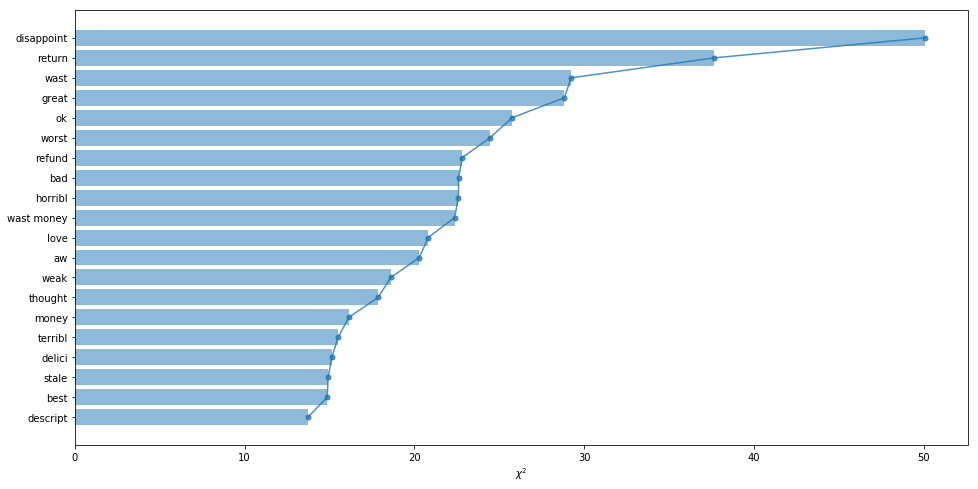

In [23]:
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# LSTM neural network

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
max_fatures = 10000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(result['Text'].values)
X1 = tokenizer.texts_to_sequences(result['Text'].values)
X1 = pad_sequences(X1)

C:\Users\DELL\Anaconda3\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [27]:
Y1 = pd.get_dummies(result['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(7500, 881) (7500, 2)
(2500, 881) (2500, 2)


In [28]:
print(X1)

[[   0    0    0 ...  882    7   35]
 [   0    0    0 ... 2631    7 2335]
 [   0    0    0 ... 1309 1428 5861]
 ...
 [   0    0    0 ... 2602  179  337]
 [   0    0    0 ...  141   33   94]
 [   0    0    0 ...   26   56   47]]


In [29]:
embed_dim = 150
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 881, 150)          1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 1,781,202
Trainable params: 1,781,202
Non-trainable params: 0
_________________________________________________________________
None


Özetlemek gerekirse, modelimiz 1 gömme, 1 LSTM ve 1 yoğun katmana sahip basit bir RNN modelidir. Toplamda 4.781.202 parametrelerin eğitilmesi gerekir.

In [30]:
batch_size = 32
model.fit(X1_train, Y1_train, nb_epoch = 10, batch_size=batch_size, verbose = 2)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
 - 992s - loss: 0.4515 - acc: 0.7995
Epoch 2/10
 - 1010s - loss: 0.2711 - acc: 0.8903
Epoch 3/10
 - 1028s - loss: 0.1930 - acc: 0.9267
Epoch 4/10
 - 1033s - loss: 0.1210 - acc: 0.9549
Epoch 5/10
 - 712s - loss: 0.0790 - acc: 0.9729
Epoch 6/10
 - 432s - loss: 0.0515 - acc: 0.9839
Epoch 7/10
 - 432s - loss: 0.0534 - acc: 0.9797
Epoch 8/10
 - 432s - loss: 0.0428 - acc: 0.9863
Epoch 9/10
 - 432s - loss: 0.0276 - acc: 0.9908
Epoch 10/10
 - 433s - loss: 0.0184 - acc: 0.9939


In [31]:
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.97
acc: 0.83


In [32]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 88.30347734457324 %
neg_acc 65.78073089700996 %
